## Finetuning pre-trained in a self-supervised manner ViT transformer on LIDC dataset.

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pickle
import torch
from torchvision import transforms
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import numpy as np
from typing import Optional, Dict
from prettytable import PrettyTable

In [2]:
%load_ext autoreload
%autoreload 2
    
from my_utils.plot_utils import plot_hists
from my_utils.norm_factors import compute_norm_factors
from End2End_Model import End2End_Model
from LIDC_DataModule import DataModule

### Dividing dataset into three sets: training, validation and test sets.

In [3]:
# Paths
local = False
if local:
    datapath = "/home/jbinda/INFORM/LIDC/dataset/"
    subsets_saving_path = "/home/jbinda/INFORM/LIDC_ViTs/dataset/splitted_sets/"
    checkpoints_path="/home/jbinda/INFORM/LIDC_ViTs/ckpt/End2End/"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)
else:
    datapath = "/home/dzban112/LIDC_ViTs/dataset/"
    subsets_saving_path = "/home/dzban112/LIDC_ViTs/dataset/splitted_sets/"
    checkpoints_path="/home/dzban112/LIDC_ViTs/ckpt/End2End/"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)

In [6]:
#Reading all annotations and extracting paths, target: benign, malignant.
df = pd.read_pickle(f"{datapath}/ALL_annotations_df.pkl")

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
folds = skf.split(X=df["path"], y=df["target"])

In [8]:
for i, (train_indices, test_indices) in enumerate(folds):
    with open(subsets_saving_path+f"train_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(train_indices), file)
    with open(subsets_saving_path+f"test_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(test_indices), file)

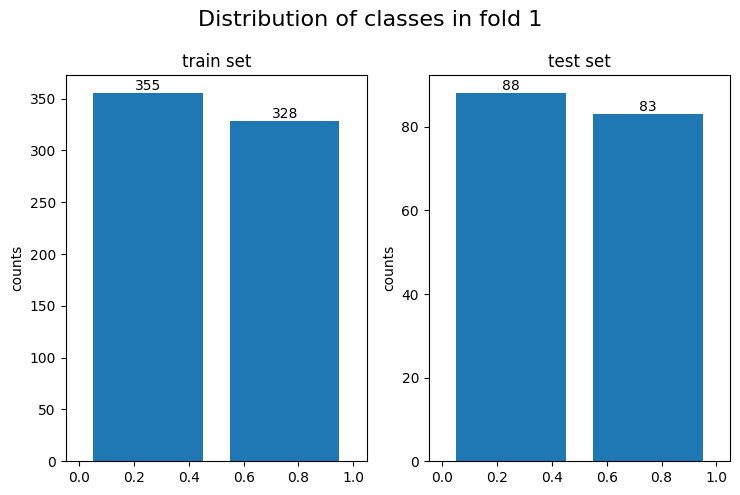

In [9]:
plot_hists(fold=1, datapath=datapath, subsets_saving_path=subsets_saving_path)

### Computing Normalization Factors

In [11]:
def prepare_norm_factors(n_splits=5):
    df = pd.read_pickle(f"{datapath}/ALL_annotations_df.pkl")
    fitted_factors = {}
    for fold in range(1, n_splits+1):
        # Computing mean and std of image pixels values.
        with open(datapath+f"/splitted_sets/train_fold_{fold}.pkl", 'rb') as file:
            train_indices = pickle.load(file)
            X_train = df.iloc[train_indices]["path"]
            mean, std = compute_norm_factors(X_train, datapath)
            
            # Creating instance of biomarker scaler
            biomarkers = df.iloc[train_indices][["subtlety", "calcification",
                                                 "margin", "lobulation",
                                                 "spiculation", "diameter",
                                                 "texture", "sphericity"]].to_numpy() #without targets
            scaler = StandardScaler().fit(biomarkers)

            # Saving in dictionary object:
            fitted_factors[f"fold_{fold}"] = (mean, std, scaler)
        

    with open(subsets_saving_path+"/"+"fitted_factors.pkl", 'wb') as f:
        pickle.dump(fitted_factors, f)
    
    return fitted_factors

fitted_factors = prepare_norm_factors(n_splits=5)

print(fitted_factors["fold_1"][0:2])
print(fitted_factors["fold_2"][0:2])
print(fitted_factors["fold_3"][0:2])
print(fitted_factors["fold_4"][0:2])
print(fitted_factors["fold_5"][0:2])

(tensor(-625.8784), tensor(363.2248))
(tensor(-631.0611), tensor(357.2651))
(tensor(-629.7866), tensor(362.4995))
(tensor(-633.4309), tensor(356.7941))
(tensor(-632.3697), tensor(356.8558))


## Finetuning End2End Model

Finetuning was performed with GPU accelaration. To train model I have used python script `train_End2End.py`.
Using first fold I have searched for the best hyperparameters and hyperparameters yielding the best model, were used to train model on five folds.

## End2End model evaluation on validation sets

In [4]:
def E2E_model_evaluation(model_name:str, version:Optional[str]=None, depth:int=1):
    res={}
    for fold in range(1,6):
        print(f"fold: {fold}")
        dm = DataModule(
            fold=fold,
            datapath=datapath,
            batch_size=16,
            num_workers=8,
            task="Classification",
            depth=depth
        )

        if version is None:
            ckpt_path = checkpoints_path+model_name+f"_{fold}"+".ckpt"
        else:
            ckpt_path = checkpoints_path+model_name+f"_{fold}"+f"-{version}"+".ckpt"
        model = End2End_Model.load_from_checkpoint(ckpt_path)
        torch.set_float32_matmul_precision('medium')
        trainer = pl.Trainer(accelerator="gpu", devices=1, precision=32, logger=False)
        model.eval()
        res[f"fold_{fold}"] = trainer.test(model, dm)
    return res


def compute_results(raw_results:Dict[str, list]):
    ACC = []
    folds = []
    mean_ACC = 0
    n = 0
    for fold in raw_results.keys():
        cur_ACC = raw_results[fold][0]["val_acc"]
        ACC.append(cur_ACC)
        folds.append(f"Fold {fold}")
        mean_ACC += cur_ACC
        n += 1
    mean_ACC = mean_ACC/n

    df = pd.DataFrame({"Fold": folds, "Accuracy": ACC})
    df.loc[len(df)] = ['Mean Accuracy', mean_ACC]
    
    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for row in df.itertuples(index=False):
        table.add_row(row)

    # Optionally, align columns
    for field in df.columns:
        table.align[field] = 'l'  # 'l' for left align, 'r' for right alig
    
    return table

#### DINO_vitb8

In [ ]:
# dino_vitb8_38 - version 0
res = E2E_model_evaluation(model_name="dino_vitb8_38")

In [8]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.9239766001701355 |
| Fold fold_3   | 0.8947368264198303 |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.9016167879104614 |
+---------------+--------------------+


In [ ]:
# dino_vitb8_38 - version v1
res = E2E_model_evaluation(model_name="dino_vitb8_38", version="v1")

In [14]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.9122806787490845 |
| Fold fold_4   | 0.8654970526695251 |
| Fold fold_5   | 0.8705882430076599 |
| Mean Accuracy | 0.8887375235557556 |
+---------------+--------------------+


In [ ]:
# dino_vitb8_38 - version v2
res = E2E_model_evaluation(model_name="dino_vitb8_38", version="v2")

In [12]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.9122806787490845 |
| Fold fold_4   | 0.8771929740905762 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8922669410705566 |
+---------------+--------------------+


#### DINO_vits8

In [ ]:
# dino_vits8_39 - version 0
res = E2E_model_evaluation(model_name="dino_vits8_39")

In [16]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8888888955116272 |
| Fold fold_2   | 0.9181286692619324 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.8830409646034241 |
| Fold fold_5   | 0.8764705657958984 |
| Mean Accuracy | 0.8910835981369019 |
+---------------+--------------------+


In [ ]:
# dino_vits8_39 - version v1
res = E2E_model_evaluation(model_name="dino_vits8_39", version="v1")

In [18]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9122806787490845 |
| Fold fold_2   | 0.9064327478408813 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.9181286692619324 |
| Fold fold_5   | 0.8588235378265381 |
| Mean Accuracy | 0.8969109058380127 |
+---------------+--------------------+


In [ ]:
# dino_vits8_39 - version v2
res = E2E_model_evaluation(model_name="dino_vits8_39", version="v2")

In [20]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8421052694320679 |
| Fold fold_2   | 0.9064327478408813 |
| Fold fold_3   | 0.9005848169326782 |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8875885844230652 |
+---------------+--------------------+


#### DINO_vits16

In [ ]:
# dino_vits16_32 - version 0
res = E2E_model_evaluation(model_name="dino_vits16_32")

In [21]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9005848169326782 |
| Fold fold_2   | 0.8654970526695251 |
| Fold fold_3   | 0.871345043182373  |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8941176533699036 |
| Mean Accuracy | 0.8864258766174317 |
+---------------+--------------------+


In [ ]:
# dino_vits16_32 - version v1
res = E2E_model_evaluation(model_name="dino_vits16_32", version="v1")

In [17]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.871345043182373  |
| Fold fold_5   | 0.8941176533699036 |
| Mean Accuracy | 0.8922738313674927 |
+---------------+--------------------+


In [ ]:
# dino_vits16_32 - version v2
res = E2E_model_evaluation(model_name="dino_vits16_32", version="v2")

In [23]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9239766001701355 |
| Fold fold_2   | 0.8830409646034241 |
| Fold fold_3   | 0.8654970526695251 |
| Fold fold_4   | 0.871345043182373  |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.8852425217628479 |
+---------------+--------------------+


#### DINO_vitb16

In [ ]:
# dino_vitb16_35 - version 0
res = E2E_model_evaluation(model_name="dino_vitb16_35")

In [8]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8888888955116272 |
| Fold fold_2   | 0.9122806787490845 |
| Fold fold_3   | 0.859649121761322  |
| Fold fold_4   | 0.9181286692619324 |
| Fold fold_5   | 0.8999999761581421 |
| Mean Accuracy | 0.8957894682884217 |
+---------------+--------------------+


In [ ]:
# dino_vitb16_35 - version v1
res = E2E_model_evaluation(model_name="dino_vitb16_35", version="v1")

In [10]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.8947368264198303 |
| Fold fold_3   | 0.859649121761322  |
| Fold fold_4   | 0.9239766001701355 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.8934296488761901 |
+---------------+--------------------+


In [11]:
# dino_vitb16_35 - version v2
res = E2E_model_evaluation(model_name="dino_vitb16_35", version="v2")

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8764705657958984
        val_loss            0.28596988320350647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [12]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9239766001701355 |
| Fold fold_2   | 0.8888888955116272 |
| Fold fold_3   | 0.8654970526695251 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8764705657958984 |
| Mean Accuracy | 0.8887444019317627 |
+---------------+--------------------+


#### SL ViTb16

In [ ]:
# vitb16_9 - version 0
res = E2E_model_evaluation(model_name="vit_b_16_9")

In [27]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.8947368264198303 |
| Fold fold_3   | 0.9005848169326782 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8957757115364074 |
+---------------+--------------------+


In [ ]:
# vitb16_9 - version v1
res = E2E_model_evaluation(model_name="vit_b_16_9", version="v1")

In [29]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.8830409646034241 |
| Fold fold_3   | 0.9005848169326782 |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8957757234573365 |
+---------------+--------------------+


In [ ]:
# vitb16_9 - version v2
res = E2E_model_evaluation(model_name="vit_b_16_9", version="v2")

In [31]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9181286692619324 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.8947368264198303 |
| Fold fold_4   | 0.9181286692619324 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.9039628505706787 |
+---------------+--------------------+


#### 3Dvit_16 - without inflation/centering strategy
There are two types of models. Models trained on input stack of slices with depth 21 and models trained on stack with depth 5. Depth 21 yielded models with better looking learning curve, but to make fair comparison with other weight initiation strategies I evaluated also model trained with depth equal 5.

##### Depth equal to 21

In [ ]:
# 3Dvit_16 - version 0 ; model trained without inflation/centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_16", depth=21)

In [10]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.847953200340271  |
| Fold fold_2   | 0.8771929740905762 |
| Fold fold_3   | 0.8421052694320679 |
| Fold fold_4   | 0.8538011908531189 |
| Fold fold_5   | 0.8705882430076599 |
| Mean Accuracy | 0.8583281755447387 |
+---------------+--------------------+


In [ ]:
# 3Dvit_16 - version 1 ; model trained without inflation/centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_16", depth=21, version="v1")

In [13]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.871345043182373  |
| Fold fold_3   | 0.8304093480110168 |
| Fold fold_4   | 0.8538011908531189 |
| Fold fold_5   | 0.8647058606147766 |
| Mean Accuracy | 0.8606604814529419 |
+---------------+--------------------+


In [ ]:
# 3Dvit_16 - version 2 ; model trained without inflation/centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_16", depth=21 , version="v2")

In [15]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.847953200340271  |
| Fold fold_2   | 0.8654970526695251 |
| Fold fold_3   | 0.8304093480110168 |
| Fold fold_4   | 0.859649121761322  |
| Fold fold_5   | 0.8588235378265381 |
| Mean Accuracy | 0.8524664521217347 |
+---------------+--------------------+


##### Depth equal to 5

In [ ]:
# 3Dvit_19 - version 0 ; model trained without inflation/centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_19", depth=5)

In [6]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.859649121761322  |
| Fold fold_2   | 0.7836257219314575 |
| Fold fold_3   | 0.8245614171028137 |
| Fold fold_4   | 0.847953200340271  |
| Fold fold_5   | 0.8588235378265381 |
| Mean Accuracy | 0.8349225997924805 |
+---------------+--------------------+


In [ ]:
# 3Dvit_19 - version 1 ; model trained without inflation/centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_19", depth=5, version="v1")

In [8]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.8362573385238647 |
| Fold fold_3   | 0.8304093480110168 |
| Fold fold_4   | 0.859649121761322  |
| Fold fold_5   | 0.8470588326454163 |
| Mean Accuracy | 0.8512831211090088 |
+---------------+--------------------+


In [ ]:
# 3Dvit_19 - version 2 ; model trained without inflation/centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_19", depth=5, version="v2")

In [10]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.8070175647735596 |
| Fold fold_3   | 0.8362573385238647 |
| Fold fold_4   | 0.8654970526695251 |
| Fold fold_5   | 0.8529411554336548 |
| Mean Accuracy | 0.8489508152008056 |
+---------------+--------------------+


#### 3Dvit_16 - with inflation strategy

In [ ]:
# 3Dvit_16 - version 0 ; model trained with inflation strategy
res = E2E_model_evaluation(model_name="3Dvit_16_17", depth=5)

In [18]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9005848169326782 |
| Fold fold_2   | 0.8771929740905762 |
| Fold fold_3   | 0.871345043182373  |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8999999761581421 |
| Mean Accuracy | 0.8876023411750793 |
+---------------+--------------------+


In [ ]:
# 3Dvit_16 - version 1 ; model trained with inflation strategy
res = E2E_model_evaluation(model_name="3Dvit_16_17", depth=5, version="v1")

In [20]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.9064327478408813 |
| Fold fold_3   | 0.871345043182373  |
| Fold fold_4   | 0.871345043182373  |
| Fold fold_5   | 0.8941176533699036 |
| Mean Accuracy | 0.8875954627990723 |
+---------------+--------------------+


In [ ]:
# 3Dvit_16 - version 2 ; model trained with inflation strategy
res = E2E_model_evaluation(model_name="3Dvit_16_17", depth=5, version="v2")

In [22]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.8830409646034241 |
| Fold fold_3   | 0.871345043182373  |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8875885844230652 |
+---------------+--------------------+


#### 3Dvit_16 - with centering strategy

In [ ]:
# 3Dvit_16 - version 0 ; model trained with centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_18", depth=5)

In [25]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.8888888955116272 |
| Fold fold_3   | 0.9122806787490845 |
| Fold fold_4   | 0.8947368264198303 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.8922600626945496 |
+---------------+--------------------+


In [ ]:
# 3Dvit_16 - version 1 ; model trained with centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_18", depth=5, version="v1")

In [27]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.8888888955116272 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.9064327478408813 |
| Fold fold_5   | 0.8941176533699036 |
| Mean Accuracy | 0.8946130037307739 |
+---------------+--------------------+


In [ ]:
# 3Dvit_16 - version 1 ; model trained with centering strategy
res = E2E_model_evaluation(model_name="3Dvit_16_18", depth=5, version="v2")

In [29]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.8771929740905762 |
| Fold fold_3   | 0.8947368264198303 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.8875816941261292 |
+---------------+--------------------+


## Finetuning biomarker regression model - TO DO !!

Fitting standard scaler for concepts z-score normalization:

In [9]:
from sklearn.preprocessing import StandardScaler

with open(subsets_saving_path+"/"+"y_train.pkl", 'rb') as f:
    biomarkers = pickle.load(f).iloc[:, 1:].to_numpy() #without targets

SCALER = StandardScaler().fit(biomarkers)
with open(subsets_saving_path+"/"+"scaler.pkl", 'wb') as f:
    pickle.dump(SCALER, f)

In [12]:
with open(subsets_saving_path+"/"+"y_train.pkl", 'rb') as f:
    biomarkers = pickle.load(f).iloc[:, 1:] #without targets

In [14]:
biomarkers.head()

,subtlety,calcification,margin,lobulation,spiculation,diameter,texture,sphericity
739,4.750000,3.750000,4.750000,1.250000,1.250000,9.563974,5.000000,4.500000
212,3.666667,5.333333,4.000000,1.666667,1.666667,6.950641,5.000000,4.000000
701,5.000000,6.000000,3.000000,2.750000,2.500000,38.389619,3.500000,3.000000
453,3.000000,6.000000,3.666667,1.000000,1.000000,7.505375,2.666667,3.333333
359,4.000000,4.500000,4.250000,3.000000,1.250000,10.479321,5.000000,2.500000


In [21]:
SCALER.mean_

array([ 4.17086039,  5.48092532,  4.08928571,  1.82467532,  1.70941558,
       13.31841242,  4.61268939,  3.8045184 ])

In [22]:
SCALER.var_

array([ 0.53394931,  0.97568008,  0.6879606 ,  0.67164221,  0.79473187,
       64.95064945,  0.57377973,  0.42182257])

Finetuning was performed using slurm queuing system on the one GPU. To train model I have used python script `train_biomarker.py`.

Training was performed with 50 epochs and I tried following sets of key hiperparameters: 
<br>
**1.** **ViT_biom_1**, 10 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**2.** **ViT_biom_2**, 20 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**3.** **ViT_biom_3**, 20 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**4.** **ViT_biom_4**, 30 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**5.** **ViT_biom_5**, 30 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**6.** **ViT_biom_6**, 40 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**7.** **ViT_biom_7**, 40 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**8.** **ViT_biom_8**, 40 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$) 
<br>
**9.** **ViT_biom_9**, 50 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**10.** **ViT_biom_10**, 50 trainable layers, dropout=0.01 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**11.** **ViT_biom_11**, 50 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**12.** **ViT_biom_12**, 50 trainable layers, dropout=0.003 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**13.** **ViT_biom_13**, 60 trainable layers, dropout=0.005 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**14.** **ViT_biom_14**, 60 trainable layers, dropout=0.0 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>
**15.** **ViT_biom_15**, 60 trainable layers, dropout=0.003 (all dropout layers), lr=3e-4 (exponential decay, $\beta=0.95$)
<br>

After having look on validation MSE curves I chosen top 5 models with best validation MSE:  
**ViT_biom_13**, **ViT_biom_11**, **ViT_biom_10**, **ViT_biom_4**, **ViT_biom_8**

## Biomarker Model evaluation on validation sets - TO DO !!

In [5]:
with open(datapath+"/splitted_sets"+"/"+"fitted_mean_std.pkl", 'rb') as f:
    dict_ = pickle.load(f)
with open(datapath+"/splitted_sets"+"/"+"scaler.pkl", 'rb') as f:
    SCALER = pickle.load(f)
    
MEAN = dict_["mean"]
STD = dict_["std"]

In [35]:
def biom_model_evaluation(checkpoint_name):
    device="cuda"
    
    test_transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
    ds_test = LIDC_Dataset_biom(
                    datadir=datapath,
                    transform=test_transform,
                    label_transform=SCALER,
                    mode="test"
                )
    test_loader = torch.utils.data.DataLoader(ds_test, shuffle=False, batch_size=16, num_workers=8)
    model = Biomarker_Model.load_from_checkpoint(f"checkpoints/Biomarkers/{checkpoint_name}").to(device)
    
    torch.set_float32_matmul_precision('medium')
    trainer = pl.Trainer(accelerator="gpu", devices=1, precision="16-mixed")
    model.eval()
    res = trainer.test(model, dataloaders=test_loader)
    return res


def evaluation_wrapper_biom(model_nr:int):
    MSE = []
    for _ in range(10):
        res = biom_model_evaluation(f"best-checkpoint_{model_nr}.ckpt")
        MSE.append(res[0]['test_mse'])
    MSE = np.array(MSE)
    return np.mean(MSE), np.std(MSE)

In [ ]:
# ViT_biom_13
mean_mse, std = evaluation_wrapper_biom(model_nr=13)

In [37]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.5773425161838531, standard deviation: 0.03359373442852333


In [ ]:
# ViT_biom_11
mean_mse, std = evaluation_wrapper_biom(model_nr=11)

In [39]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.5906020283699036, standard deviation: 0.028045997638796182


In [ ]:
# ViT_biom_10
mean_mse, std = evaluation_wrapper_biom(model_nr=10)

In [41]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.6141557216644287, standard deviation: 0.028909996747307744


In [ ]:
# ViT_biom_4
mean_mse, std = evaluation_wrapper_biom(model_nr=4)

In [43]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.623276162147522, standard deviation: 0.023270278423259114


In [ ]:
# ViT_biom_8
mean_mse, std = evaluation_wrapper_biom(model_nr=8)

In [45]:
print(f"Mean MSE: {mean_mse}, standard deviation: {std}")

Mean MSE: 0.5965319812297821, standard deviation: 0.02622306491194194
